In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/test.zip')]

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/b58cc561e560_01.jpg'),
 PosixPath('data/carvana/train/6343156803f9_16.jpg'),
 PosixPath('data/carvana/train/d9b2ded58b72_14.jpg'),
 PosixPath('data/carvana/train/7ac210ba75a1_02.jpg'),
 PosixPath('data/carvana/train/1c5748340af8_01.jpg')]

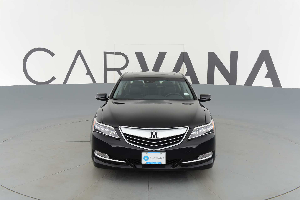

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/e5fc2c1c4a8b_06_mask.gif'),
 PosixPath('data/carvana/train_masks/2a4a8964ebf3_11_mask.gif'),
 PosixPath('data/carvana/train_masks/b44091aa62e4_13_mask.gif'),
 PosixPath('data/carvana/train_masks/d1a3af34e674_10_mask.gif'),
 PosixPath('data/carvana/train_masks/245f9c9eab8a_03_mask.gif')]

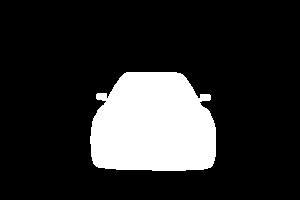

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

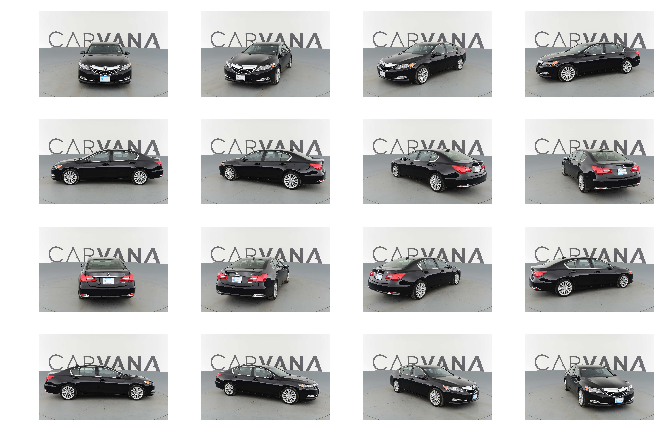

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [15]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [16]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [17]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [18]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [19]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
# line below was calling resize_img - needs to be updated to call resize_mask
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [20]:
(PATH/'train-128').mkdir(exist_ok=True)

In [21]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [22]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [23]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

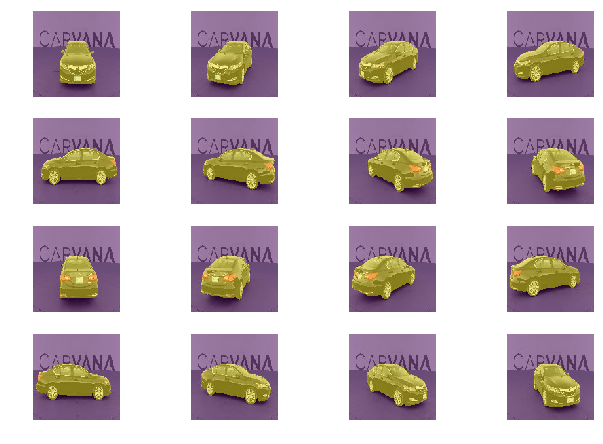

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [25]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [26]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [27]:
len(x_names)//16//5*16

1008

In [28]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [29]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [51]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [52]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

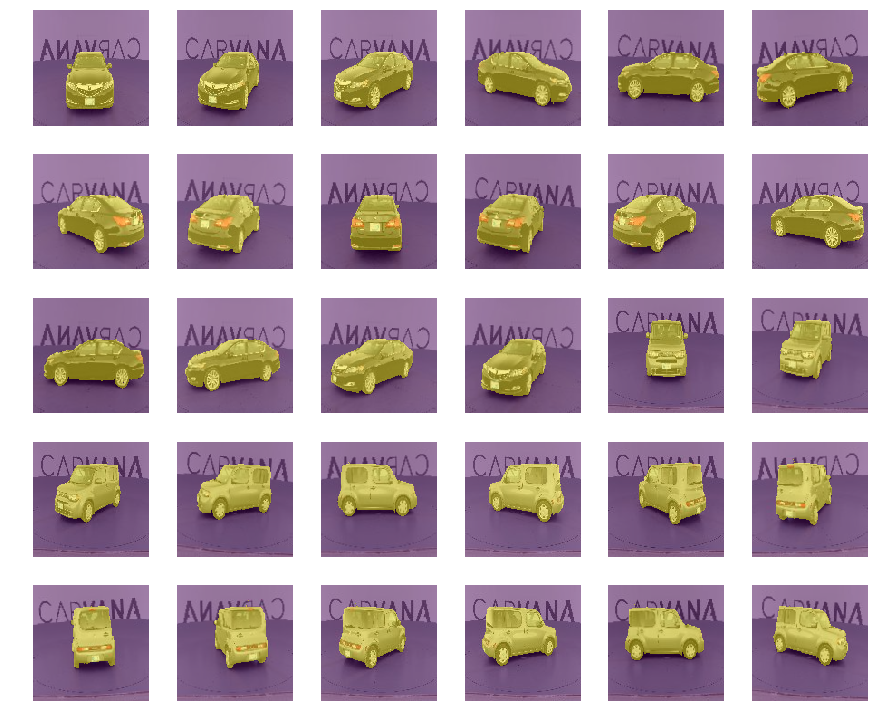

In [53]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [54]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [67]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [68]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [69]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

In [70]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 56/64 [00:07<00:01,  7.46it/s, loss=2.64] 


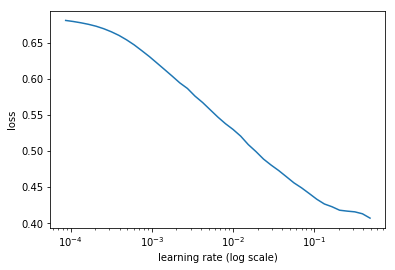

In [71]:
learn.lr_find()
learn.sched.plot()

In [72]:
lr=4e-2

In [73]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                  
    0      0.178043   0.158871   0.938457  
    1      0.126603   0.111293   0.951455                  
    2      0.105854   0.111138   0.954925                  
    3      0.093455   0.092314   0.958971                   
    4      0.085375   0.087275   0.960765                   



[0.087274894, 0.9607646465301514]

In [74]:
learn.save('tmp')

In [75]:
learn.load('tmp')

In [84]:
py,ay = learn.predict_with_targs()

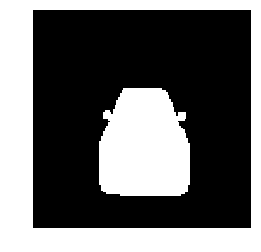

In [91]:
show_img(np.rollaxis(ay[0], 0, 3))

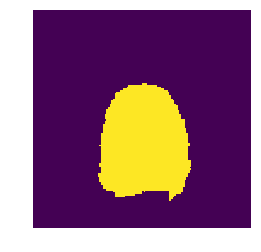

In [92]:
show_img(py[0][0]>0);

In [93]:
learn.unfreeze()

In [131]:
nb = 1000
cut_div = 10
div = 20
cycle_iter = 0
lr = .01

cut_pt = nb//cut_div
if cycle_iter>cut_pt:
    pct = 1 - (cycle_iter - cut_pt)/(cut_pt*(cut_div-1))
else: pct = cycle_iter/cut_pt
res = lr * (1 + pct*(div-1)) / div
cycle_iter += 1
res

0.0005

In [94]:
learn.bn_freeze(True)

In [95]:
lrs = np.array([lr/100,lr/10,lr])/4

In [96]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                   
    0      0.073449   0.059906   0.976795  
    1      0.051861   0.059961   0.971791                   
    2      0.043002   0.038101   0.982105                   
    3      0.037949   0.036847   0.985706                   
    4      0.033082   0.030954   0.986575                   
    5      0.109039   0.638268   0.808514                   
    6      0.287333   0.241977   0.877203                  
    7      0.192974   0.094697   0.957984                  
    8      0.109086   0.063944   0.969264                  
    9      0.070539   0.053868   0.974148                   
    10     0.054758   0.046625   0.980126                   
    11     0.045947   0.041938   0.980595                   
    12     0.041759   0.039144   0.983153                   
    13     0.038164   0.037253   0.982967                   
    14     0.036115   0.035524   0.983973                   
    15     0.033976   0.038326   0.98155    

[0.024388388, 0.9899791069328785]

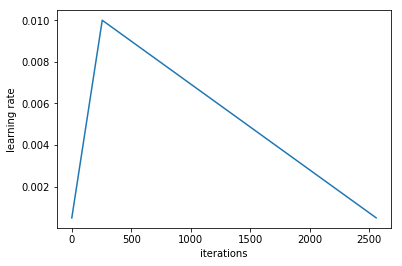

In [100]:
learn.sched.plot_lr()

In [101]:
learn.save('0')

In [102]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

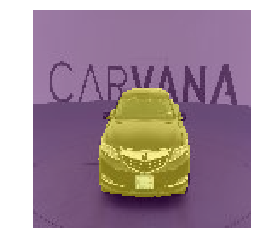

In [103]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

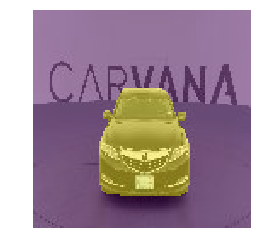

In [107]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [ ]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [ ]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [ ]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [ ]:
learn.load('0')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [ ]:
sz = 1024
bs = 4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [ ]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [ ]:
learn.load('512')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/8

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## Fin

In [ ]:
x,y = next(iter(md.val_dl))

In [ ]:
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
